In [12]:
import pandas as pd

# Define column names as per KDDCup dataset
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
             "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
             "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
             "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
             "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
             "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
             "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack", "last_flag"]

# Load training and test datasets
train_df = pd.read_csv("data/Train.csv", names=col_names)
test_df = pd.read_csv("data/Test.csv", names=col_names)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode binary target: 0 for normal, 1 for any attack
train_df['target'] = train_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['target'] = test_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)

# Label encode categorical columns
for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col]) 

# Drop unused columns
train_df.drop(['attack', 'last_flag'], axis=1, inplace=True)
test_df.drop(['attack', 'last_flag'], axis=1, inplace=True)

# Separate features and labels
X_train_full = train_df.drop('target', axis=1)
y_train_full = train_df['target']

# Use only normal samples for training
X_train_norm = X_train_full[y_train_full == 0]

# Normalize features based on training normal samples
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_norm)

# Prepare test set
X_test = test_df.drop('target', axis=1)
y_test = test_df['target'].values
X_test_scaled = scaler.transform(X_test)

In [16]:
# Reshape for LSTM input: (samples, time steps, features)
X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Define input shape
input_dim = X_train_seq.shape[2]
inputs = Input(shape=(1, input_dim))

# Encoder (1 layer)
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)

# Bottleneck
repeated = RepeatVector(1)(encoded)

# Decoder (1 layer)
decoded = LSTM(64, activation='relu', return_sequences=True)(repeated)

# Output layer
outputs = TimeDistributed(Dense(input_dim))(decoded)

# Compile model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 41)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        27,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 41)          │         2,665 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,825 (245.41 KB)

 Trainable params: 62,825 (245.41 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with callback
history = model.fit(X_train_seq, X_train_seq,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.1,
                    shuffle=True,
                    callbacks=[early_stop])


Epoch 1/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.6094 - val_loss: 0.0788
Epoch 2/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2149 - val_loss: 0.0409
Epoch 3/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1087 - val_loss: 0.0270
Epoch 4/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0581 - val_loss: 0.0258
Epoch 5/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0309 - val_loss: 0.0207
Epoch 6/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0331 - val_loss: 0.0300
Epoch 7/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0600 - val_loss: 0.0127
Epoch 8/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0811 - val_loss: 0.0379
Epoch 9/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0331 - val_loss: 0.0109
Epoch 10/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0272 - val_loss: 0.0126
Epoch 11/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0124 - val_loss: 0.0098
Epoch 12/100
474/474 ━━━━━━━━━

In [19]:
import numpy as np

# Predict on normal training samples
X_pred_train = model.predict(X_train_seq)
mse_train = np.mean(np.mean(np.square(X_train_seq - X_pred_train), axis=2), axis=1)

# Threshold: 95th percentile of training reconstruction error
threshold = np.percentile(mse_train, 95)
print(f"Threshold set at: {threshold:.4f}")


2105/2105 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Threshold set at: 0.0107


In [20]:
# Predict on test data
X_pred_test = model.predict(X_test_seq)
mse_test = np.mean(np.mean(np.square(X_test_seq - X_pred_test), axis=2), axis=1)

# Predict anomalies
y_pred = (mse_test > threshold).astype(int)


705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))



Confusion Matrix:
[[ 8998   713]
 [ 2399 10434]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7895    0.9266    0.8526      9711
           1     0.9360    0.8131    0.8702     12833

    accuracy                         0.8620     22544
   macro avg     0.8628    0.8698    0.8614     22544
weighted avg     0.8729    0.8620    0.8626     22544



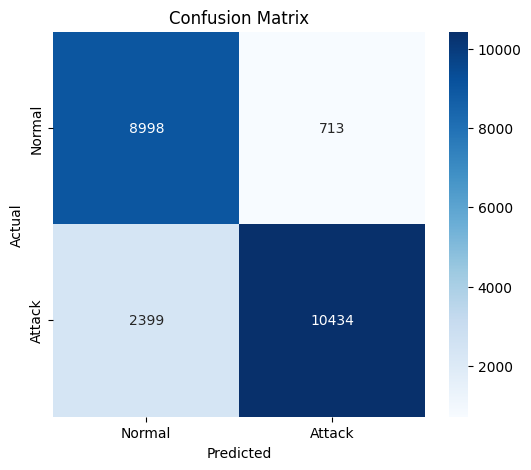

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

ROC AUC Score: 0.9553


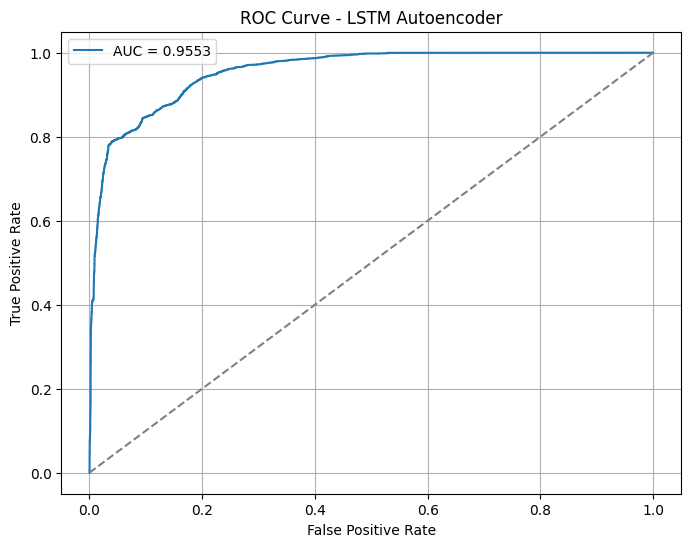

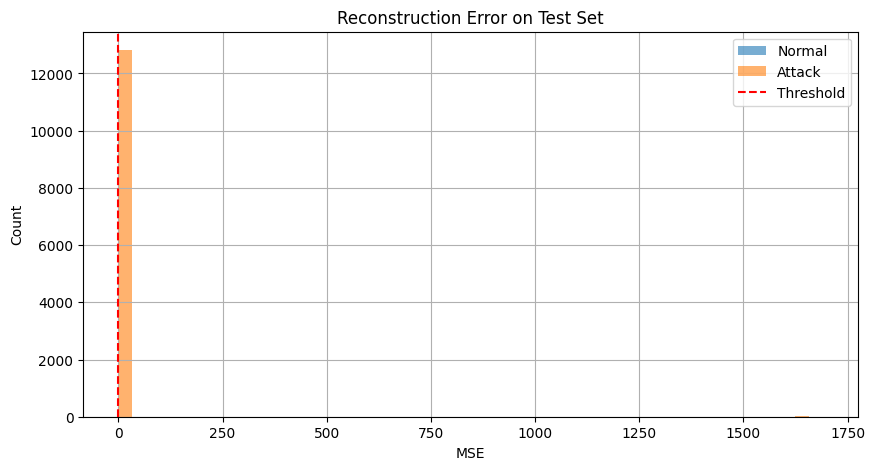

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

# ROC AUC
roc_auc = roc_auc_score(y_test, mse_test)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, mse_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LSTM Autoencoder")
plt.legend()
plt.grid()
plt.show()

# Reconstruction Error Distribution
plt.figure(figsize=(10, 5))
plt.hist(mse_test[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(mse_test[y_test == 1], bins=50, alpha=0.6, label='Attack')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error on Test Set")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()